# CS7180 Problem Set 2: Exploring gradient norms for multi-layer perceptrons (25 points)


Before you start, make sure to read the problem description in the handout pdf.

In [ ]:
#!pip install jupyter ipywidgets torch torchvision matplotlib tqdm

In [ ]:
# Setup
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from tqdm import trange
import seaborn as sns
import pandas as pd


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set random seed for reproducibility
seed = 1234
# cuDNN uses nondeterministic algorithms, set some options for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)

In [ ]:
# Initial transform (convert to PyTorch Tensor only)
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_data = datasets.MNIST('data',
                            train=True,
                            download=True,
                            transform=transform)
test_data = datasets.MNIST('data',
                           train=False,
                           download=True,
                           transform=transform)
# Calculate training data mean and standard deviation to apply normalization to data
# train_data.data are of type uint8 (range 0,255) so divide by 255.
train_mean = train_data.data.double().mean() / 255.
train_std = train_data.data.double().std() / 255.
print(f'Train Data: Mean={train_mean}, Std={train_std}')

# Add normalization of train and test data using calculated training mean and standard deviation
# This will convert data to be in range[-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((train_mean,), (train_std,))])
train_data.transform = transform
test_data.transform = transform

Train Data: Mean=0.1306604762738429, Std=0.3081078071313976


In [ ]:
batch_size = 128
torch.manual_seed(seed)
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=2)

## Part 1: Implement a multi-layer neural network (5 points)

Write a class that constructs a multi-layer neural network as specified in the handout. Similar to the previous homework, the class consists of two methods, an initialization that sets up the architecture of the model, and a forward pass function given an input feature.

Note 1: The number of layers is given by the length of the hidden_sizes array.

Note 2: Each hidden layer uses ReLU activation, and the last layer uses log softmax activation that maps feature representations to log probabilities.

In [ ]:
class MNISTClassifierMLP(torch.nn.Module):

    def __init__(self, input_size, hidden_sizes, output_size):
        """
        Hidden_sizes is a list of hidden sizes, e.g. [32, 32, 32]
        """
        super().__init__()
        self.flatten = torch.nn.Flatten(start_dim=1)

        self.depth = len(hidden_sizes) + 1


        # ------------------
        # Write your implementation here.
        self.linears = [nn.Linear(input_size, hidden_sizes[0], bias=False)]
        self.linears.extend([nn.Linear(hidden_sizes[0], hidden_sizes[0], bias=False) for i in range(len(hidden_sizes)-1)])
        self.linears.append(nn.Linear(hidden_sizes[0], output_size, bias=False))
        self.acts = [nn.ReLU() for i in range(len(hidden_sizes))]
        self.acts.append(nn.LogSoftmax())
        self.linears = nn.ModuleList(self.linears)
        self.acts = nn.ModuleList(self.acts)
        # ------------------        
        
    def forward(self, x):
        x = self.flatten(x)
        # Iterate over self.linears and self.acts
        # ------------------
        # Write your implementation here.
        
        for i in range(self.depth):
            x = self.acts[i](self.linears[i](x))
          
        # ------------------        
            
        return x

In [ ]:
# Hyperparameters
lr = 0.01
max_epochs = 40

# Model arguments
input_size = 28 * 28
hidden_sizes = [128] * 3
output_size = 10

model = MNISTClassifierMLP(input_size, hidden_sizes, output_size).to(DEVICE)
print(model)

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

def train_one_epoch(train_loader, model, device, optimizer, epoch):
    model.train()
    train_loss = 0
    gradient_norms = []
    for i, (img, label) in enumerate(train_loader):
        img, label = img.to(device), label.to(device)

        # Compute loss and backprop
        optimizer.zero_grad()
        output = model(img)
        loss = torch.nn.functional.nll_loss(output, label)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        gradient_norms.append(get_gradient_norms(model))

    # Compute average loss over batches
    train_loss /= len(train_loader)

    # Compute average of norms of gradients over batches
    # Convert to numpy array and compute mean
    gradient_norms = np.array(gradient_norms)
    gradient_norms = gradient_norms.mean(0)

    return train_loss, gradient_norms

def test_one_epoch(test_loader, model, device):
    model.eval()
    test_loss = 0
    num_correct = 0
    with torch.no_grad():
        for i, (img, label) in enumerate(test_loader):
            img, label = img.to(device), label.to(device)

            output = model(img)
            # Get index of largest log-probability and use that as prediction
            pred = output.argmax(dim=1, keepdim=True)
            num_correct += (pred == label.view_as(pred)).sum().item()

            test_loss += torch.nn.functional.nll_loss(output, label).item()

    # Compute average loss over batches
    test_loss /= len(test_loader)

    return test_loss, num_correct

MNISTClassifierMLP(
  (flatten): Flatten()
  (linears): ModuleList(
    (0): Linear(in_features=784, out_features=128, bias=False)
    (1): Linear(in_features=128, out_features=128, bias=False)
    (2): Linear(in_features=128, out_features=128, bias=False)
    (3): Linear(in_features=128, out_features=10, bias=False)
  )
  (acts): ModuleList(
    (0): ReLU()
    (1): ReLU()
    (2): ReLU()
    (3): LogSoftmax(dim=None)
  )
)


In [ ]:
#!pip install torchsummary
#!pip install torchviz
from torchsummary import summary
summary(model, (1, 28, 28))
# from torchviz import make_dot
# make_dot(y)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,352
              ReLU-3                  [-1, 128]               0
            Linear-4                  [-1, 128]          16,384
              ReLU-5                  [-1, 128]               0
            Linear-6                  [-1, 128]          16,384
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 10]           1,280
        LogSoftmax-9                   [-1, 10]               0
Total params: 134,400
Trainable params: 134,400
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.51
Estimated Total Size (MB): 0.53
-------------------------------------------

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


## Part 2: Measure the gradient norm of each layer during training (5 points)

1. Implement the function get_gradient_norms, which returns an array that contains the Frobenius norm of the gradient matrix in every hidden layer.


2. Use the training the test procedures provided above to train the multi-layer perception for max_epochs epochs. Remember to store the gradient norm of each hidden layer at every epoch.

In [ ]:
def get_gradient_norms(model):
    # Only get gradients for linear layers
    # Calculate the Frobenius norm
    # Return as list of floats, not torch.Tensors
    # Size should be equal to depth

    norms = []

    # ------------------
    # Write your implementation here.
    for p in model.parameters():
      param_norm = p.grad.data.norm(2).item()
      norms.append(param_norm)
    # ------------------        
        
    return norms

train_losses = []
gradient_norms = []
test_losses = []
test_correct = []


for epoch in trange(max_epochs, desc='Epochs', leave=True):
    # ------------------
    # Write your implementation here.
    #for epoch in range(max_epochs):
      train_loss, grad_norms = train_one_epoch(train_loader, model, DEVICE, optimizer, epoch)
      test_loss, test_corr = test_one_epoch(test_loader, model, DEVICE)
      train_losses.append(train_loss)
      gradient_norms.append(grad_norms)
      test_losses.append(test_loss)
      test_correct.append(test_corr)
    # ------------------        

gradient_norms = np.array(gradient_norms)


Epochs:   0%|          | 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.

Epochs: 100%|██████████| 40/40 [06:21<00:00,  9.53s/it]


## Part 3: Plot the norm of the gradients of each layer during training (15 points)

1. Plot the gradient norm of each layer as the number of epochs increases.


2. Discuss your findings and include your figure in the submitted solutions.

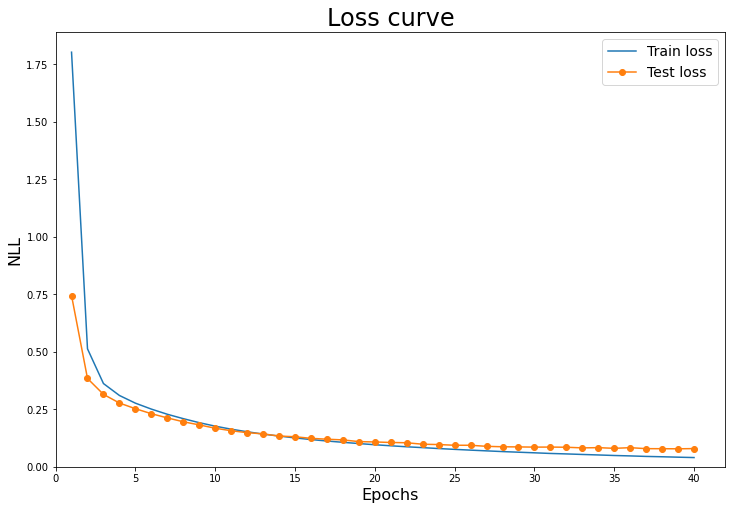

In [ ]:
# Draw training loss curve
fig = plt.figure(figsize=(12, 8))
plt.plot(range(1, max_epochs + 1), train_losses, label='Train loss')
plt.plot(range(1, max_epochs + 1), test_losses, label='Test loss', marker='o')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.title('Loss curve', fontsize=24)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('NLL', fontsize=16)
plt.legend(loc='upper right', fontsize=14)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


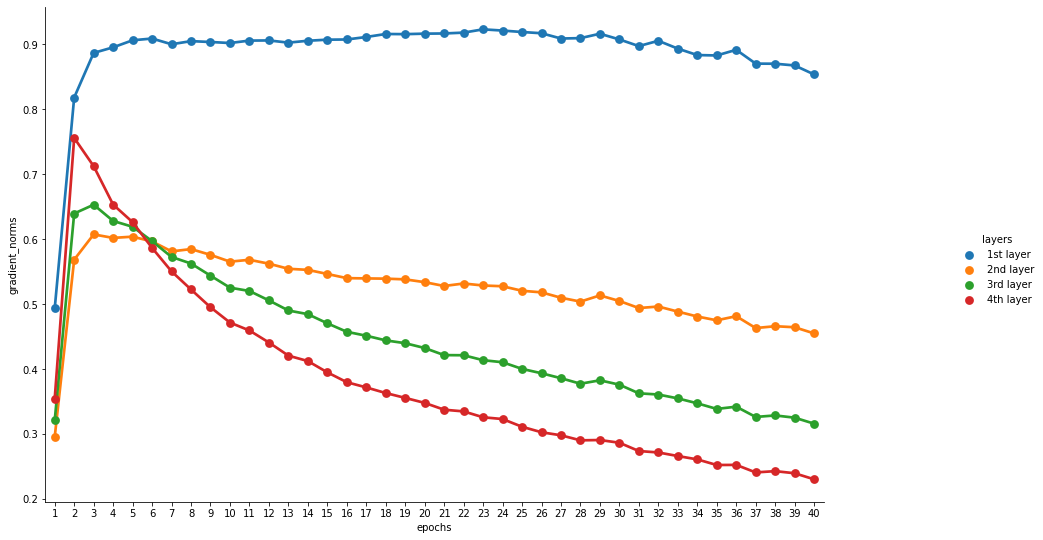

In [ ]:
# Plot the gradient norms of each layer vs the number of epochs
# ------------------
# Write your implementation here.
df = pd.DataFrame(gradient_norms, columns=['1st layer', '2nd layer', '3rd layer', '4th layer'])
df['epochs'] = [i+1 for i in range(40)]
df = df.melt('epochs', var_name='layers',  value_name='gradient_norms')
g = sns.factorplot(x="epochs", y="gradient_norms", hue='layers', data=df)
g.fig.set_figwidth(15.27)
g.fig.set_figheight(7.7)
# ------------------